In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

import myfunc

%matplotlib inline

# Feature impotance

In [2]:
# Prepares movie data.

movie_set = myfunc.make_movie_set()

In [3]:
# Alternate to preparing movie data - loads prepared movie data.

movie_set = pd.read_csv('data/reg_movie_set.csv')

In [3]:
# Sets up the train-test split
X = movie_set.drop('Gross', axis=1)
y = movie_set['Gross']

x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=99)

y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# Sanity check
print('Train - Predictors shape', x_train.shape)
print('Test - Predictors shape', x_test.shape)
print('Train - Target shape', y_train.shape)
print('Test - Target shape', y_test.shape)

Train - Predictors shape (472, 43)
Test - Predictors shape (148, 43)
Train - Target shape (472, 1)
Test - Target shape (148, 1)


In [4]:
# Scales the training data.

scaler = StandardScaler()

x_train_standard = scaler.fit_transform(x_train)
x_val_standard = scaler.transform(x_val)

In [5]:
# Gets a score from a linear regression - starting point.

linear_regression = LinearRegression()
linear_regression.fit(x_train_standard, y_train)
linear_regression.score(x_train_standard, y_train)

0.6015598392405963

In [6]:
linear_regression.score(x_val_standard, y_val)

0.6346387499426862

In [7]:
# Runs LassoCV on scaled data.

kfold = KFold(shuffle=True, random_state=2**32-1)
lasso_cv = LassoCV(alphas=np.arange(734480, 734490, 1), normalize=False, cv=kfold)
lasso_cv.fit(x_train_standard, y_train)

LassoCV(alphas=array([734480, 734481, 734482, 734483, 734484, 734485, 734486, 734487,
       734488, 734489]),
        cv=KFold(n_splits=5, random_state=4294967295, shuffle=True))

In [8]:
alphas = lasso_cv.alphas_
errors = lasso_cv.mse_path_
n_folds = 5

df_errors = pd.DataFrame(index=alphas, columns=[f'fold_{i+1}' for i in range(n_folds)], data=errors)
df_errors['error_mean'] = df_errors.mean(axis=1)
df_errors.sort_values('error_mean').head()

,fold_1,fold_2,fold_3,fold_4,fold_5,error_mean
734485,4.295034e+15,6.743862e+15,4.544695e+15,2.762819e+15,8.964603e+15,5.462203e+15
734484,4.295049e+15,6.743855e+15,4.544694e+15,2.762818e+15,8.964598e+15,5.462203e+15
734486,4.295017e+15,6.743871e+15,4.544696e+15,2.762820e+15,8.964609e+15,5.462203e+15
734483,4.295063e+15,6.743848e+15,4.544694e+15,2.762817e+15,8.964593e+15,5.462203e+15
734487,4.295000e+15,6.743883e+15,4.544697e+15,2.762820e+15,8.964615e+15,5.462203e+15


In [9]:
lasso_cv.alpha_

734485

In [10]:
lasso_cv.score(x_val_standard, y_val)

0.6215319961732839

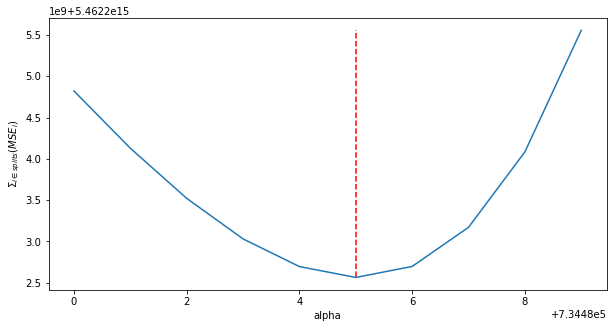

In [11]:
plt.figure(figsize=(10, 5))

g = sns.lineplot(data=df_errors,
                 x=df_errors.index,
                 y='error_mean')

# Show the selected alpha, above
plot_alpha = 734485
g.vlines(plot_alpha, df_errors['error_mean'].min(), df_errors['error_mean'].max(), 
         color='red', linestyles='dashed')

g.set_xlabel('alpha')
g.set_ylabel('$\Sigma_{i \in splits}(MSE_i)$');

In [12]:
cols = movie_set.drop('Gross', axis=1).columns
pd.Series(index=cols, data=lasso_cv.coef_)

UserRating                         2.571912e+07
Metascore                          1.841826e+07
Budget                             3.906805e+07
Theaters                           3.815422e+07
WaltDisneyStudiosMotionPictures    1.130631e+07
UniversalPictures                  4.325280e+06
TwentiethCenturyFox               -0.000000e+00
SonyPicturesEntertainment(SPE)     4.418981e+06
ParamountPictures                 -2.632394e+06
WarnerBros.                       -1.264819e+05
PG                                -7.175569e+06
PG-13                              0.000000e+00
R                                  0.000000e+00
1                                 -0.000000e+00
2                                  2.009860e+06
3                                 -2.070284e+06
4                                  0.000000e+00
5                                 -1.477932e+06
6                                  1.471959e+06
7                                  9.478217e+05
8                                  1.331

# RE run linear regression

In [14]:
drop_1 = ['WarnerBros.', 'PG-13', 'R', 1, 8, 'DirMS', 'Animation', 'Romance', 'Thea2']

x_train2 = x_train.drop(columns=drop_1)
y_train2 = y_train.copy()

x_val2 = x_val.drop(columns=drop_1)
y_val2 = y_val.copy()
scaler = StandardScaler()
x_train2_scaled = scaler.fit_transform(x_train2)
x_val2_scaled = scaler.transform(x_val2)

linear_regression = LinearRegression()
linear_regression.fit(x_train2_scaled, y_train2)
linear_regression.score(x_train2_scaled, y_train2)

0.6011222442871085

In [15]:
linear_regression.score(x_val2_scaled, y_val2)

0.6354679914947068

In [16]:
for i in range(-10,5):
    ridge = Ridge(alpha=10**i)
    ridge.fit(x_train_standard, y_train)
    print(ridge.coef_, ridge.score(x_val_standard, y_val))

[[ 30971378.34989613  23706132.61233052  42150552.81036266
   19337174.12085691   9758392.62272063   2138331.52736232
   -3087159.02365834   2687449.96379911  -5865130.86670259
   -3993453.19241197  -6026534.52554938   2687762.80576896
    2234220.2871718     182157.01261474   3388450.45520241
   -2777010.04289557    124877.20870019  -2449248.09738951
    2104254.94102462   1875440.71066886   2249619.63007521
   -4991103.04189374  -2965535.92273395  -5330501.98717404
    7295126.4678707  -14578366.23514118  -5348260.00274202
   -8371286.90877126  -4079674.43991553   2246995.55211345
    -608342.2586276    1140668.27871936  -3502070.90059969
  -11859646.22045717   5044076.50969911    330703.93433168
   -1503188.10825529  -4533852.88251877   4822998.21649398
   -1483014.69796151   -308327.55015081   -879559.27582164
   19225782.66607098]] 0.6346816582543977
[[ 30971378.34939235  23706132.61230968  42150552.81007939
   19282176.91904547   9796170.28340086   2185135.69271205
   -3043415.27

In [17]:
ridge_cv = RidgeCV()
ridge_cv.fit(x_train_standard, y_train)
print(ridge_cv.coef_, ridge_cv.score(x_val_standard, y_val))

pd.Series(index=cols, data=ridge_cv.coef_[0])

[[ 2.68754216e+07  2.27090538e+07  3.93624413e+07  1.93022375e+07
   1.00733980e+07  2.03328949e+06 -3.13126663e+06  2.65033645e+06
  -5.83556465e+06 -3.83877413e+06 -6.03083254e+06  2.81667112e+06
   2.20539089e+06 -8.46120522e+03  3.19003860e+06 -2.63405004e+06
   1.37235898e+05 -2.24292798e+06  2.15371317e+06  1.80821672e+06
   2.10124964e+06 -4.88800430e+06 -3.06512832e+06 -5.19698840e+06
   7.36016847e+06 -1.03024625e+07 -4.66599702e+06 -7.48324478e+06
  -2.65814750e+06  2.74204577e+06 -2.42104073e+05  1.56401696e+06
  -2.83416532e+06 -1.11645486e+07  4.87022563e+06  4.74981057e+05
  -9.07705771e+05 -3.98947522e+06  4.84581516e+06 -1.48192601e+06
  -4.62938555e+05 -7.65679308e+05  1.93022375e+07]] 0.6295928817750162


UserRating                         2.687542e+07
Metascore                          2.270905e+07
Budget                             3.936244e+07
Theaters                           1.930224e+07
WaltDisneyStudiosMotionPictures    1.007340e+07
UniversalPictures                  2.033289e+06
TwentiethCenturyFox               -3.131267e+06
SonyPicturesEntertainment(SPE)     2.650336e+06
ParamountPictures                 -5.835565e+06
WarnerBros.                       -3.838774e+06
PG                                -6.030833e+06
PG-13                              2.816671e+06
R                                  2.205391e+06
1                                 -8.461205e+03
2                                  3.190039e+06
3                                 -2.634050e+06
4                                  1.372359e+05
5                                 -2.242928e+06
6                                  2.153713e+06
7                                  1.808217e+06
8                                  2.101

In [18]:
for i in range(-10,5):
    lasso = Lasso(alpha=10**i)
    lasso.fit(x_train_standard, y_train)
    print(lasso.coef_, lasso.score(x_val_standard, y_val))

[ 3.09713783e+07  2.37061326e+07  4.21505528e+07  3.74084288e+07
  1.20576158e+07  4.98692564e+06 -4.24827912e+05  5.14738680e+06
 -3.33949250e+06 -7.63861716e+05 -8.02244898e+06  2.38080164e+05
 -9.51062448e+04  2.36211257e+04  3.21575712e+06 -2.96727084e+06
 -3.66173612e+04 -2.63472019e+06  1.90056635e+06  1.66550441e+06
  2.07692629e+06 -5.17411537e+06 -3.17749265e+06 -5.54834571e+06
  7.04504536e+06 -1.45783662e+07 -5.34826000e+06 -8.37128691e+06
 -4.07967444e+06  2.24699555e+06 -6.08342259e+05  1.14066828e+06
 -3.50207090e+06 -1.18596462e+07  5.04407651e+06  3.30703934e+05
 -1.50318811e+06 -4.53385288e+06  4.82299822e+06 -1.48301470e+06
 -3.08327550e+05 -8.79559276e+05  1.15452798e+06] 0.634681658254449
[ 3.09713783e+07  2.37061326e+07  4.21505528e+07  3.74084288e+07
  1.20576158e+07  4.98692564e+06 -4.24827912e+05  5.14738680e+06
 -3.33949250e+06 -7.63861716e+05 -8.02244898e+06  2.38080164e+05
 -9.51062448e+04  2.36211257e+04  3.21575712e+06 -2.96727084e+06
 -3.66173612e+04 -2.63

In [19]:
lasso_cv2 = LassoCV()
lasso_cv2.fit(x_train2_scaled, y_train2)
print(lasso_cv2.score(x_val2_scaled, y_val))

cols = x_train2.columns
pd.Series(index=cols, data=lasso_cv2.coef_)

0.6177184513205793


UserRating                         2.308877e+07
Metascore                          1.773783e+07
Budget                             3.825245e+07
Theaters                           3.782407e+07
WaltDisneyStudiosMotionPictures    1.083149e+07
UniversalPictures                  3.859663e+06
TwentiethCenturyFox               -0.000000e+00
SonyPicturesEntertainment(SPE)     4.033243e+06
ParamountPictures                 -2.584143e+06
PG                                -6.849425e+06
2                                  1.230693e+06
3                                 -2.145257e+06
4                                 -0.000000e+00
5                                 -1.469664e+06
6                                  8.138437e+05
7                                  2.560919e+05
9                                 -4.636393e+06
10                                -2.947360e+06
11                                -5.100124e+06
12                                 5.609693e+06
DirUR                             -7.229

In [21]:
drop_2 = ['TwentiethCenturyFox', 4, 'Adventure', 'Fantasy', 'Sport', 'Mystery']
x_train3 = x_train2.drop(columns=drop_2)
y_train3 = y_train2.copy()

x_val3 = x_val2.drop(columns=drop_2)
y_val3 = y_val2.copy()
scaler = StandardScaler()
x_train3_standard = scaler.fit_transform(x_train3)
x_val3_standard = scaler.transform(x_val3)

linear_regression = LinearRegression()
linear_regression.fit(x_train3_standard, y_train3)
linear_regression.score(x_train3_standard, y_train3)

0.600415367713403

In [22]:
linear_regression.score(x_val3_standard, y_val3)

0.6323445055518917

In [23]:
lasso_cv3 = LassoCV()
lasso_cv3.fit(x_train3_standard, y_train3)
print(lasso_cv3.score(x_val3_standard, y_val3))

cols = x_train3.columns
pd.Series(index=cols, data=lasso_cv3.coef_)

0.6201571703261606


UserRating                         2.442872e+07
Metascore                          1.789789e+07
Budget                             3.851700e+07
Theaters                           3.793947e+07
WaltDisneyStudiosMotionPictures    1.106685e+07
UniversalPictures                  4.059035e+06
SonyPicturesEntertainment(SPE)     4.258809e+06
ParamountPictures                 -2.630219e+06
PG                                -7.135742e+06
2                                  1.347680e+06
3                                 -2.369854e+06
5                                 -1.726309e+06
6                                  8.228724e+05
7                                  2.725657e+05
9                                 -4.842995e+06
10                                -3.124121e+06
11                                -5.322753e+06
12                                 5.638191e+06
DirUR                             -8.607608e+06
Action                            -5.921683e+06
Sci-Fi                             2.368

In [24]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.57393913, 0.55224549, 0.52603563, 0.42903512, 0.2548833 ])

# Run model on test set

In [26]:
final_x_test = x_test.drop(columns=['WarnerBros.', 'PG-13', 'R', 1, 8, 'DirMS', 'Animation', 'Romance', 'Thea2', 'TwentiethCenturyFox', 4, 'Adventure', 'Fantasy', 'Sport', 'Mystery'])
final_x_test_standard = scaler.transform(final_x_test)
linear_regression.score(final_x_test_standard, y_test)

0.3858599401000212

Text(0.5, 1.0, 'Linear-Regression Model Residual Plot')

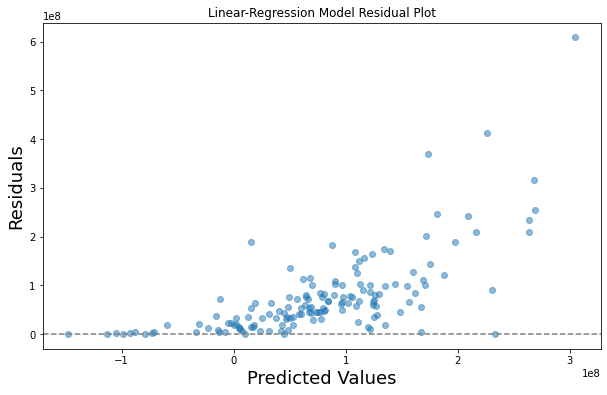

In [28]:
final_x_test = x_test.drop(columns=['WarnerBros.', 'PG-13', 'R', 1, 8, 'DirMS', 'Animation', 'Romance', 'Thea2', 'TwentiethCenturyFox', 4, 'Adventure', 'Fantasy', 'Sport', 'Mystery'])
final_x_test_standard = scaler.transform(final_x_test)
test_set_pred = linear_regression.predict(final_x_test_standard)

plt.figure(figsize=(10, 6))
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);
plt.title('Linear-Regression Model Residual Plot')

In [56]:
plt.figure(figsize=(10, 6))
sns.jointplot(x=test_set_pred, y=y_test, data=movie_set, kind='reg');

ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 739 and the vector passed to `x` has length 148.

In [29]:
final_x_test.columns

Index([                     'UserRating',                       'Metascore',
                                'Budget',                        'Theaters',
       'WaltDisneyStudiosMotionPictures',               'UniversalPictures',
        'SonyPicturesEntertainment(SPE)',               'ParamountPictures',
                                    'PG',                                 2,
                                       3,                                 5,
                                       6,                                 7,
                                       9,                                10,
                                      11,                                12,
                                 'DirUR',                          'Action',
                                'Sci-Fi',                          'Comedy',
                              'Thriller',                           'Drama',
                                 'Music',                       'Biography',

In [30]:
greyhound = pd.Series([7.0, 64, 50300000, 4300, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7.0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).values.reshape(1, -1)
greyhound_scaled = scaler.transform(greyhound)
greyhound_gross = linear_regression.predict(greyhound)

In [31]:
greyhound_gross

array([[2.02625851e+15]])

In [32]:
tenet = pd.Series([7.8, 69, 205000000, 4300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 7.21, 1, 1, 0, 0, 0, 0, 0, 0, 0]).values.reshape(1, -1)
tenet_scaled = scaler.transform(tenet)
tenet_gross = linear_regression.predict(tenet)

In [33]:
tenet_gross

array([[8.25759507e+15]])

In [34]:
spenser = pd.Series([5.4, 66, 200000000, 4300, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 7.2, 1, 0, 0, 0, 1, 0, 0, 0, 0]).values.reshape(1, -1)
spenser_scaled = scaler.transform(spenser)
spenser_gross = linear_regression.predict(spenser)

In [35]:
spenser_gross

array([[8.05619427e+15]])

In [36]:
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=2**32-1)

In [37]:
grid = GridSearchCV(estimator=Lasso(normalize=True),  # must be an sklearn estimator
                    param_grid={'alpha': np.arange(1000, 1000000, 1000)},
                    cv=kfold,
                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
                    return_train_score=True)
grid.fit(x_train_standard, y_train)
grid.best_estimator_

Lasso(alpha=119000, normalize=True)

In [38]:
grid.best_score_

-5447717174313054.0

This is promising - When I run this over x_standard, y_standard instead of x_train, y_train, score is very high.  Run on x_train_standard.

# Polynomial fit - pair_regressions2
# X_standard is x_train scaled.



In [39]:
linear_regression = LinearRegression()
x_train_for_poly = x_train.copy()
x_val_for_poly = x_val.copy()
p = PolynomialFeatures(degree=2, interaction_only=True)
x_train_poly = p.fit_transform(x_train_for_poly)
x_val_poly = p.transform(x_val_for_poly)
linear_regression.fit(x_train_poly, y_train)
linear_regression.score(x_train_poly, y_train)

0.9980567361019972

In [40]:

linear_regression.score(x_val_poly, y_val)

-37.49456832199781

In [41]:
lasso_cv2.alpha_

1015242.8932391731

In [45]:
movie_set_corr = movie_set.corr()

In [46]:
heat_map_df = movie_set[['Gross', 'UserRating', 'Metascore', 'Budget', 'Theaters', 'WaltDisneyStudiosMotionPictures', 'PG-13', 'DirUR', 'DirMS', 'Action', 'Adventure', 'Sci-Fi']]
heat_map_corr = heat_map_df.corr()

(12.5, -0.5)

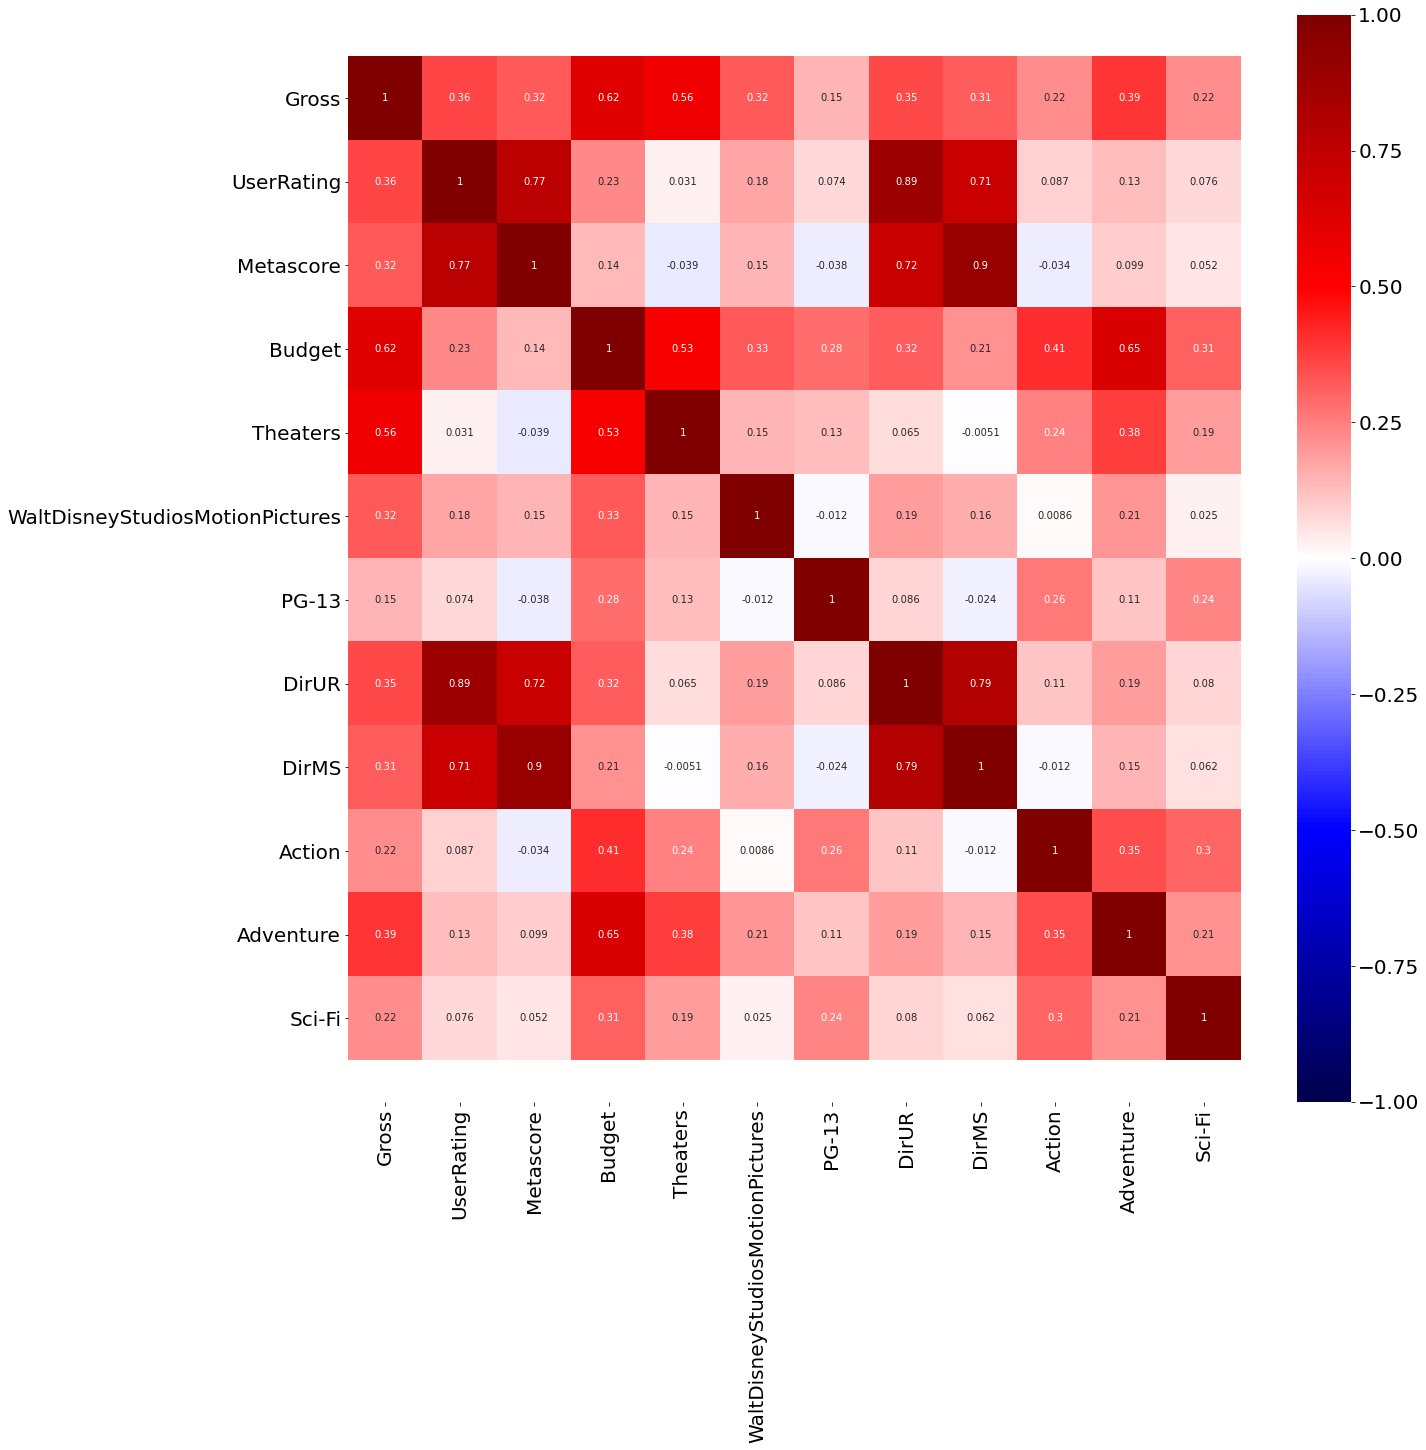

In [47]:
plt.figure(figsize=(20, 20))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
sns.heatmap(heat_map_corr,
            cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.gca().set_ylim(len(heat_map_corr)+0.5, -0.5)

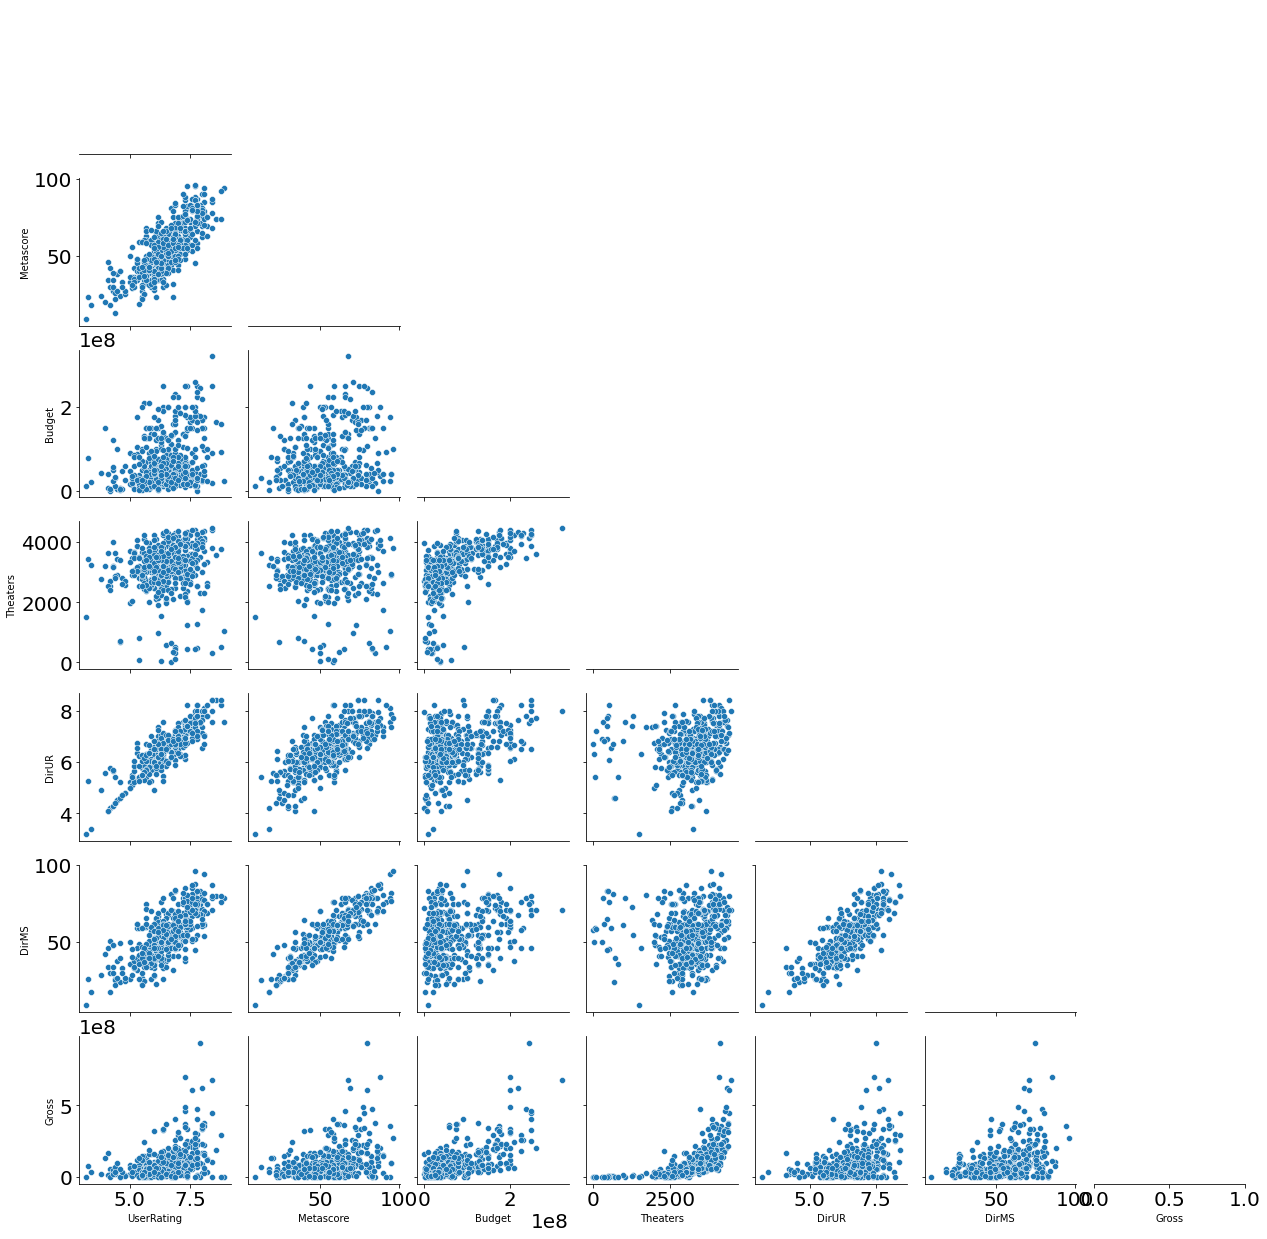

In [48]:
# sns.pairplot(movie_set, height=1.5, aspect=1)
heat_map_df = heat_map_df[['UserRating', 'Metascore', 'Budget', 'Theaters', 'DirUR', 'DirMS', 'Gross']]
g = sns.PairGrid(heat_map_df.sample(frac=0.6), diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde=False)

In [49]:
lr = LinearRegression()

X = movie_set['Budget'].values.reshape(-1, 1)
# X = movie_set['Theaters', 'UserRating', 'MetaScore', 'Budget', 'PG', 'PG-13', 'R', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'].values.reshape(-1, 1)
y = movie_set['Gross']

lr.fit(X, y)
lr.score(X, y)

0.3880669168264299

In [51]:
X = movie_set[['Budget', 'DirUR', 'Theaters']]
y = movie_set['Gross']

lr.fit(X, y)
lr.score(X, y)

0.49864203856401534

In [54]:
plt.figure(figsize=(10, 7))
plt.scatter(fit.predict(), fit.resid)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);

NameError: name 'fit' is not defined

## To investigate

In [ ]:
prediction = cls.predict(x_test)
cls.get_params()

In [ ]:
print('Co-efficient of linear regression',cls.coef_)
print('Intercept of linear regression model',cls.intercept_)
print('Mean Square Error', metrics.mean_squared_error(y_test, prediction))
print('Model R^2 Square value', metrics.r2_score(y_test, prediction))